## Data Understanding

In [156]:
%%capture
%pip install sidetable

In [157]:
import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [158]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)


In [159]:
#Verificando o tamanho e as primeiras linhas do dataset
df = pd.read_csv('/content/asset_register.csv', encoding='latin1')
print(df.shape)
df.head()

(193393, 8)


,id,asset_id,deleted_at,created_at,updated_at,participant_id,number,value
0,2702c756-046f-4c6f-8c88-b9bd36381420,0a97fc64-0530-40dd-afd6-0907b00128a8,NaN,2024-08-19 17:24:26.658095,2024-08-19 17:24:27.168214,aeb72c25-9995-4e46-ba73-13942df9c41c,000012345,0.01
1,f6f607c7-119a-47ca-9ea0-0d38ef305844,5e2ea74d-ecec-424a-90ee-5d2627f979ef,NaN,2024-08-20 14:19:27.450411,2024-08-20 14:19:29.593190,3ecdfafa-8647-4a6d-9088-441fe796cd12,130071-001,26774.00
2,0808b9b9-b43b-49f3-8cb2-6f8c519f558f,17b85404-8bc7-4f6e-883c-baf41ec012da,NaN,2024-08-20 14:19:26.561130,2024-08-20 14:19:29.642760,3ecdfafa-8647-4a6d-9088-441fe796cd12,130069-001,8860.00
3,a8e1076d-4a58-495b-9388-cceea3feb39c,44db3952-4bd4-45ab-afb8-95fc45013e51,NaN,2024-08-20 14:19:28.481696,2024-08-20 14:19:29.692849,3ecdfafa-8647-4a6d-9088-441fe796cd12,130069-003,9128.50
4,9f3b1f4c-9ab5-4878-8f03-8e38c3dadabf,5d754d93-4fdd-43af-96a1-b147f07226a6,NaN,2024-08-20 14:19:29.225451,2024-08-20 14:19:29.738058,3ecdfafa-8647-4a6d-9088-441fe796cd12,130069-002,8860.00


In [160]:
#Analisando o tipo de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193393 entries, 0 to 193392
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              193393 non-null  object 
 1   asset_id        193393 non-null  object 
 2   deleted_at      2700 non-null    object 
 3   created_at      193393 non-null  object 
 4   updated_at      193393 non-null  object 
 5   participant_id  193393 non-null  object 
 6   number          193393 non-null  object 
 7   value           193393 non-null  float64
dtypes: float64(1), object(7)
memory usage: 11.8+ MB


In [161]:
#Analisando a quantidade de nulos do dataset
df.isna().sum().sort_values(ascending=False)

,0
deleted_at,190693
id,0
asset_id,0
created_at,0
updated_at,0
participant_id,0
number,0
value,0


## Data Preparation

In [162]:
#Retirando duplicatas que foram
df = df[df['deleted_at'].isnull()]

In [163]:
#Verificando se existem valores duplicados
df['asset_id'].nunique()

190693

In [164]:

df['created_at'] = pd.to_datetime(df['created_at'])

# Formatar a coluna 'created_at' no formato desejado
#df['created_at'] = df['created_at'].dt.strftime('%d %B, %Y')

In [165]:
#Data máxima e Minima
df.created_at.agg(['min', 'max'])

,created_at
min,2023-06-29 17:54:29.988490
max,2024-10-21 14:14:59.874051


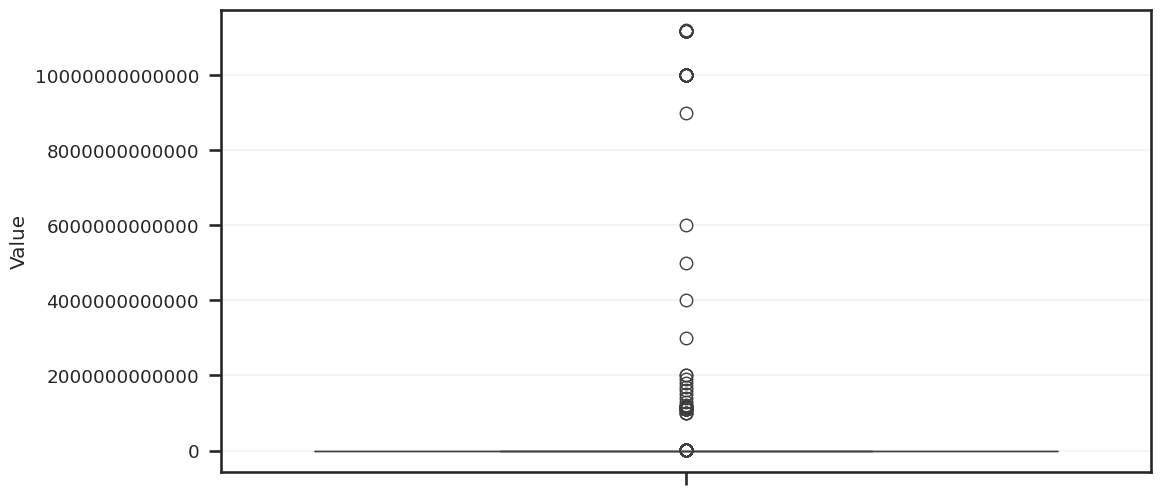

In [166]:
# Criando o boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y="value")

# Desativando a notação científica no eixo Y
plt.ticklabel_format(style='plain', axis='y')

# Exibindo o gráfico
plt.ylabel("Value")
plt.show()

<Axes: >

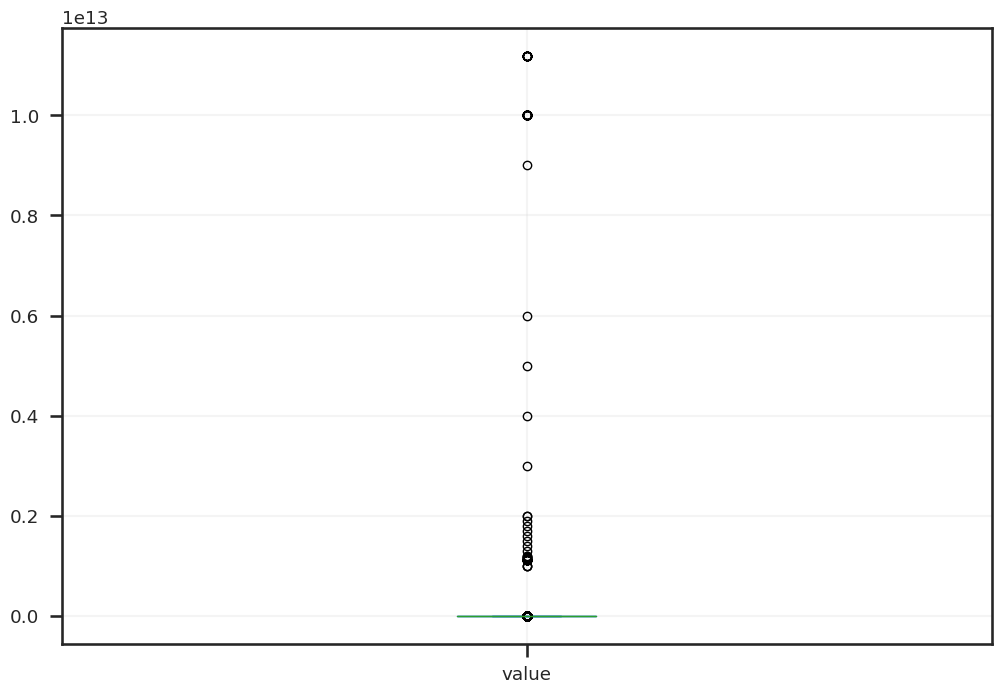

In [167]:
#Analisando outliers
df[['value']].plot.box()

In [168]:
#Removendo outliers acimade 1 mi
df = df.query('value < 100000')
df = df.query('value > 0')

<Axes: >

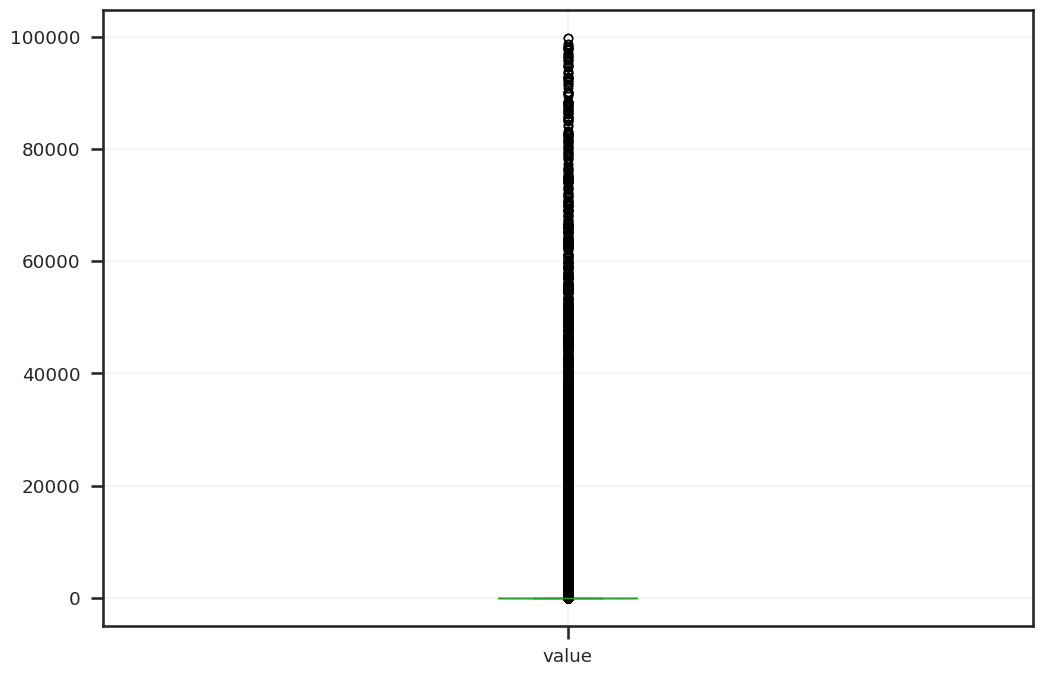

In [169]:
#Analisando outliers
df[['value']].plot.box()

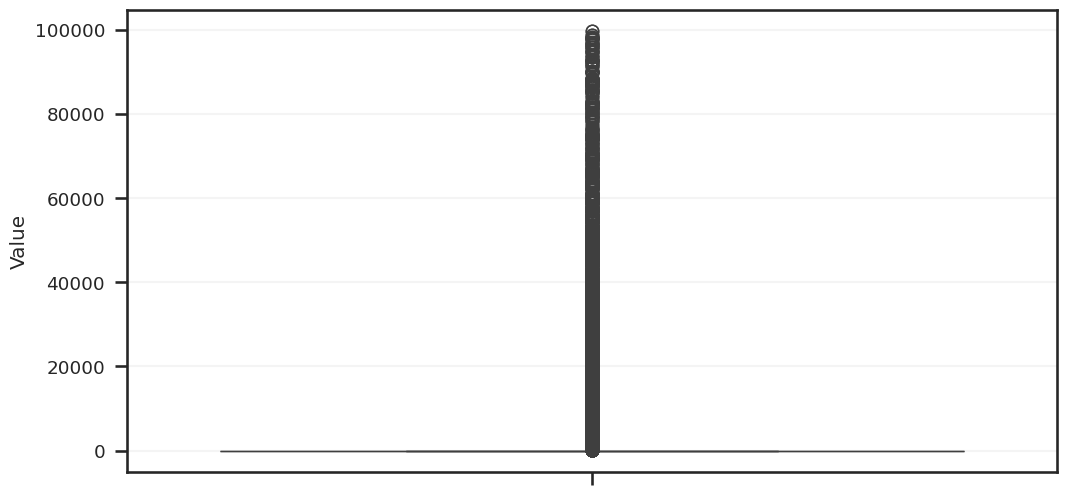

In [170]:
# Criando o boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y="value")

# Desativando a notação científica no eixo Y
plt.ticklabel_format(style='plain', axis='y')

# Exibindo o gráfico
plt.ylabel("Value")
plt.show()

In [171]:
df.shape

(190163, 8)

In [172]:
#Agrupando por Ressência, Frequência e Valor
df_rfm = (
  df.groupby('participant_id')
  .agg(
      R = ('created_at', lambda x: (pd.Timestamp.today() - x.max()).days),
      F = ('asset_id', 'nunique'),
      M = ('value', 'mean')
  )
)

styled_df_rfm = df_rfm.style \
    .background_gradient(subset='R', cmap='Reds', low=0.2, high=0.8) \
    .background_gradient(subset='F', cmap='Blues', low=0.2, high=0.8) \
    .background_gradient(subset='M', cmap='Greens', low=0.2, high=0.8) \
    .format(precision=2) \
    .set_caption("Tabela de Segmentação RFM") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('color', '#333')]},
        {'selector': 'th', 'props': [('border', '1px solid #ddd'), ('font-size', '14px')]}
    ])

# Exibindo a tabela estilizada
styled_df_rfm

,R,F,M
participant_id,,,
00d69eec-21b4-470b-b21b-cb3932bb7fdb,9,32,670.02
04282b7d-ed52-4bbe-abb8-eea6cc77ba9f,340,15,895.32
0eafc30d-c4d8-448d-8f96-0bef3d412e6e,18,6,0.01
12067bd9-36cf-49ed-83fd-4766c5e9968a,11,11525,4583.32
14b855a6-304e-48d1-8780-a8fb7c24c8eb,102,2848,10155.55
1e9f5a61-1586-4b7b-87a5-7fc88add826e,179,35,645.30
27b2e89c-b062-45a0-ada9-9039539067c3,184,10,91.19
2a4a4f9e-9bea-4e31-9f42-e6c438a37f2d,31,38,12005.67
317ca004-5c44-4f21-a88b-e4a953e64632,18,591,606.76


In [173]:
df_rfm.describe()

,R,F,M
count,47.000000,47.000000,47.000000
mean,99.212766,4046.021277,4809.065712
std,115.253772,22298.047476,8322.188320
min,5.000000,1.000000,0.010000
25%,16.000000,6.000000,397.334167
50%,37.000000,18.000000,2136.642683
75%,166.500000,452.000000,4691.662219
max,443.000000,153049.000000,47697.830000


In [174]:
#df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
#df_rfm_clip.describe()

In [175]:
#Retirando Outliers
df_rfm= df_rfm.query('F < 100000 & M < 20000')
df_rfm = df_rfm.apply(scale).query('F<4')

In [176]:
#Conferindo distribuição dos dados
#df_rfm.apply(scale).plot.box()

In [177]:
from sklearn.preprocessing import PowerTransformer

In [178]:
scaler = PowerTransformer()

In [179]:
# Transformando em distribuição normal, fazendo STD e Mean em 1
df_rfm = pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_rfm

,R,F,M
participant_id,,,
00d69eec-21b4-470b-b21b-cb3932bb7fdb,-1.097321,-0.512961,-0.731944
04282b7d-ed52-4bbe-abb8-eea6cc77ba9f,1.624059,-0.591251,-0.595691
0eafc30d-c4d8-448d-8f96-0bef3d412e6e,-0.886809,-0.633539,-1.175803
14b855a6-304e-48d1-8780-a8fb7c24c8eb,0.494165,2.045339,1.505026
1e9f5a61-1586-4b7b-87a5-7fc88add826e,1.066680,-0.499358,-0.747287
27b2e89c-b062-45a0-ada9-9039539067c3,1.092752,-0.614672,-1.111940
2a4a4f9e-9bea-4e31-9f42-e6c438a37f2d,-0.605190,-0.485819,1.628818
317ca004-5c44-4f21-a88b-e4a953e64632,-0.886809,1.144055,-0.771361
31c92e5e-23d0-45a9-8885-8d9c4a7a5c18,-1.195029,-0.605281,0.731074


In [180]:
#Analisando Outliers
#df_rfm.plot.box()

##Modeling


####KMEANS

In [181]:
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,43.000000,43.000000,43.000000
mean,-0.009363,-0.000226,-0.008958
std,0.995474,1.011358,0.995728
min,-1.195029,-0.657286,-1.175803
25%,-0.898188,-0.633539,-0.905558
50%,-0.464337,-0.586588,-0.018137
75%,0.997130,-0.052010,0.736558
max,1.612617,2.081004,1.625929


In [182]:
df_rfm_clip_scaled = df_rfm_clip.apply(scale)
#df_rfm_clip_scaled = df_rfm_clip

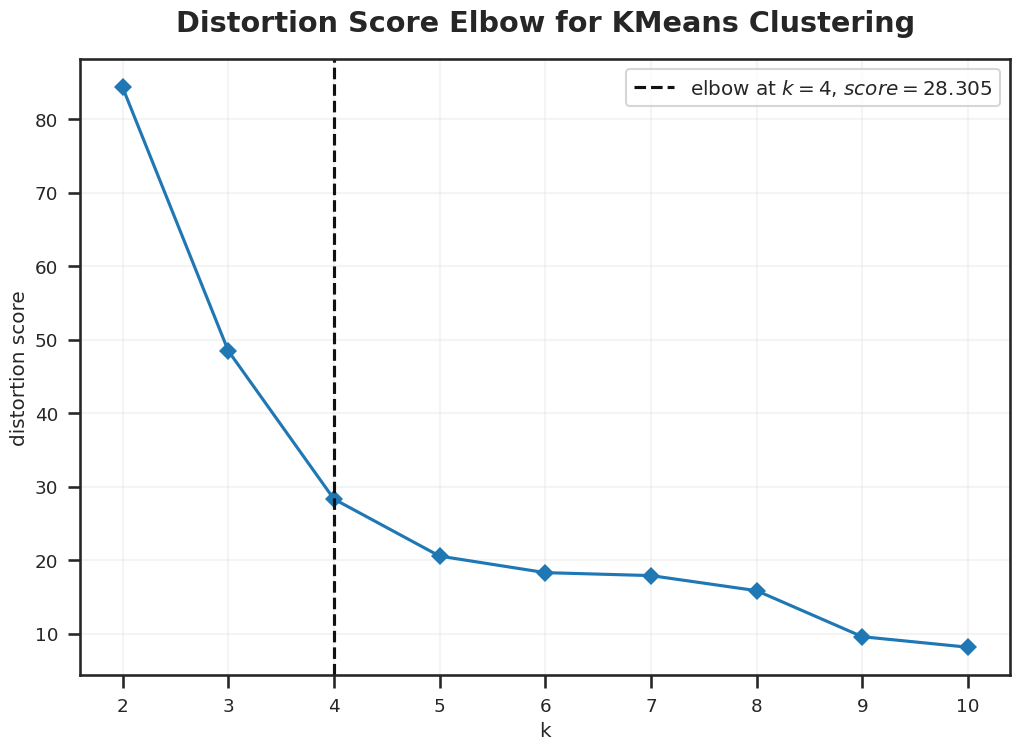

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [183]:
#Encontrando a melhor quantidade de Clusters
kelbow_visualizer(KMeans(), df_rfm_clip_scaled, k=10, timings=False)

In [184]:
# Create list of dictionaries

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = df_rfm_clip_scaled.copy()

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,84.339641,0.382668,1.059150,21.710724
3,49.115813,0.423758,0.858191,32.528907
4,28.121966,0.488731,0.718454,46.633100
5,20.543781,0.513893,0.762623,50.153089
6,19.508780,0.441404,0.775158,41.531815
7,14.496049,0.460821,0.724501,47.393861
8,12.090168,0.458824,0.675696,48.349133
9,8.944734,0.490744,0.574465,57.043049
10,7.494829,0.471074,0.617909,59.443515


In [185]:
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_rfm_clip_scaled)

In [186]:
px.scatter_3d(df_rfm_clip_scaled, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

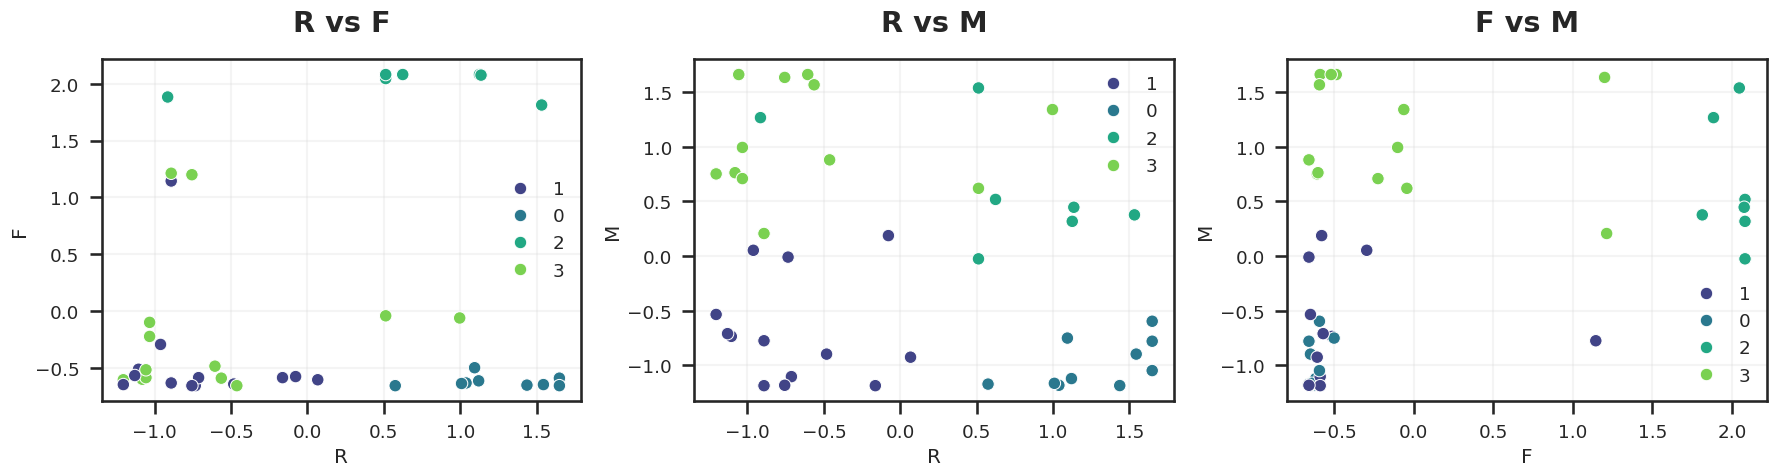

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# Definir o tamanho da figura
plt.figure(figsize=(18, 5))

# Gráfico 1: R vs F
plt.subplot(1, 3, 1)  # Primeira posição de 3 gráficos
sns.scatterplot(data=df_rfm_clip_scaled, x='R', y='F', hue=kmeans_labels.astype(str), palette='viridis')
plt.title('R vs F')

# Gráfico 2: R vs M
plt.subplot(1, 3, 2)  # Segunda posição de 3 gráficos
sns.scatterplot(data=df_rfm_clip_scaled, x='R', y='M', hue=kmeans_labels.astype(str), palette='viridis')
plt.title('R vs M')

# Gráfico 3: F vs M
plt.subplot(1, 3, 3)  # Terceira posição de 3 gráficos
sns.scatterplot(data=df_rfm_clip_scaled, x='F', y='M', hue=kmeans_labels.astype(str), palette='viridis')
plt.title('F vs M')

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Mostrar os gráficos
plt.show()


####Interpretação dos clusters

In [188]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)

C1: Ressência bem alta (Ruim), frequencia baixa (Ruim) e valores baixo (Ruim)
C2: Ressência  baixa (bom), frequencia baixa (Ruim) e valores altos (bom)
C3: Ressência  baixa (bom), frequencia alta (bom) e valores altos (bom)

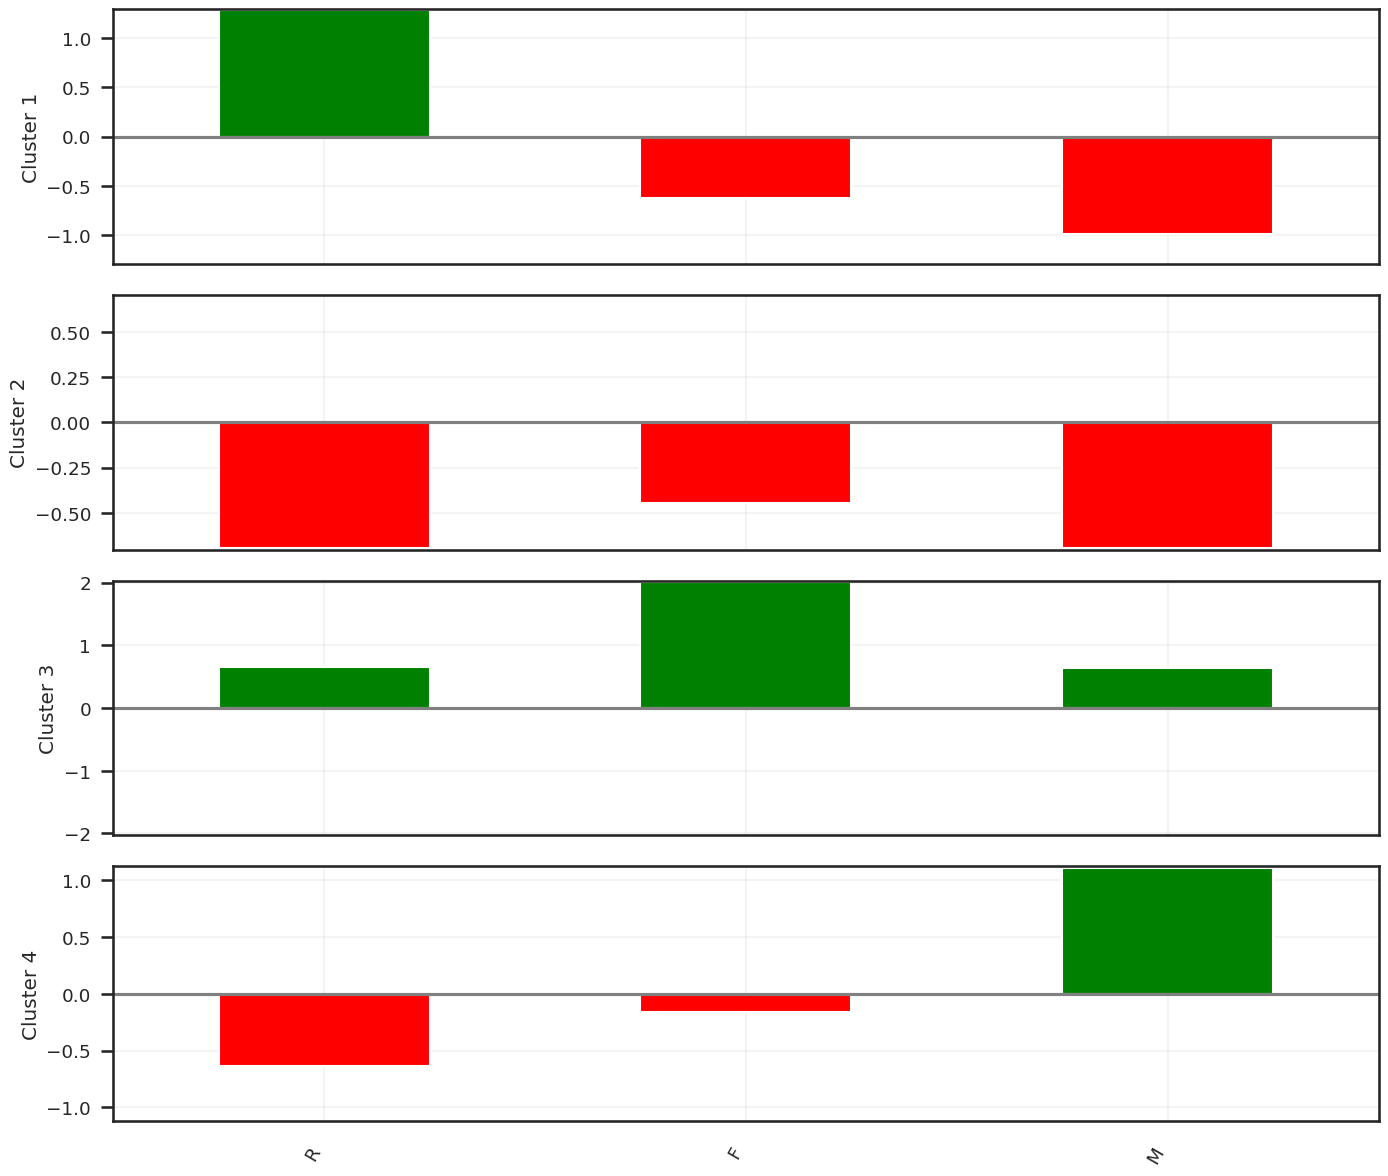

In [189]:
# Adaptado do livro "Practical Statistics for Data Scientists"
fig,axes = plt.subplots(nrows=4, figsize=(14,12), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [190]:
import pandas as pd

# Criando o DataFrame dos centros (centroides) dos clusters com os dados do KMeans
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df_rfm_clip_scaled.columns)
centers.index = [f'Cluster {i+1}' for i in range(len(centers))]  # Renomeia os índices para 'Cluster 1', 'Cluster 2', etc.

# Estilizando a tabela para apresentação
styled_table = centers.style \
    .applymap(lambda x: 'color: green' if x > 0 else 'color: red') \
    .background_gradient(cmap='coolwarm', axis=0) \
    .format(precision=2) \
    .set_caption("Tabela de Centros dos Clusters (RFM)") \
    .set_table_styles([
        {'selector': 'caption', 'props': [('text-align', 'center'), ('font-size', '16px'), ('color', '#333')]},
        {'selector': 'th', 'props': [('border', '1px solid #ddd'), ('font-size', '14px')]}
    ])

# Exibindo a tabela estilizada
styled_table


<ipython-input-190-3910963f8480>:9: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,R,F,M
Cluster 1,1.28,-0.62,-0.99
Cluster 2,-0.70,-0.45,-0.69
Cluster 3,0.65,2.01,0.63
Cluster 4,-0.63,-0.16,1.11


In [191]:
df_rfm_clip_scaled['Cluster'] = kmeans_labels

# Opcional: Renomeando os clusters para valores mais informativos
# Exemplo: {0: 'Cluster A', 1: 'Cluster B', ...}
cluster_names = {0: 'Cluster 1', 1: 'Cluster 2', 2: 'Cluster 3', 3: 'Cluster 4'}
df_rfm_clip_scaled['Cluster_Label'] = df_rfm_clip_scaled['Cluster'].map(cluster_names)

# Visualizando o DataFrame com os clusters rotulados
df_rfm_clip_scaled.head()

,R,F,M,Cluster,Cluster_Label
participant_id,,,,,
00d69eec-21b4-470b-b21b-cb3932bb7fdb,-1.105839,-0.512976,-0.734680,1,Cluster 2
04282b7d-ed52-4bbe-abb8-eea6cc77ba9f,1.648637,-0.591303,-0.596224,0,Cluster 1
0eafc30d-c4d8-448d-8f96-0bef3d412e6e,-0.891868,-0.633611,-1.185720,1,Cluster 2
14b855a6-304e-48d1-8780-a8fb7c24c8eb,0.511803,2.046530,1.538474,2,Cluster 3
1e9f5a61-1586-4b7b-87a5-7fc88add826e,1.093728,-0.499367,-0.750272,0,Cluster 1


###Estratégias de Desconto Explicadas


1. **Cluster 1:** Pequeno desconto para incentivar compras recorrentes e fidelização.

2. **Cluster 2:** Desconto maior para reativar clientes inativos e engajá-los novamente.

3. **Cluster 3:** Recompensa por fidelidade, com um desconto significativo para clientes de alto valor.

4. **Cluster 4:** Desconto condicionado ao valor da compra, incentivando clientes ocasionais a comprarem com maior frequência.

In [192]:
# Estratégias de desconto por cluster
def recomendar_desconto(cluster):
    if cluster == 'Cluster 1':
        # Cluster 1: Clientes recentes, baixa frequência e baixo valor
        return "5% de desconto nas taxas para incentivar novas transações e fidelização"
    elif cluster == 'Cluster 2':
        # Cluster 2: Clientes inativos de baixo valor
        return "10% de desconto para reativar clientes inativos"
    elif cluster == 'Cluster 3':
        # Cluster 3: Clientes leais e de alto valor
        return "Oferta exclusiva de 15% em transações para premiar a fidelidade"
    elif cluster == 'Cluster 4':
        # Cluster 4: Clientes ocasionais de alto valor
        return "10% de desconto em transações acima de determinado valor para incentivar maior frequência"
    else:
        return "Nenhuma recomendação específica"

# Aplicando as recomendações de desconto ao DataFrame
df_rfm_clip_scaled['Recomendacao_Desconto'] = df_rfm_clip_scaled['Cluster_Label'].apply(recomendar_desconto)

# Visualizando as primeiras linhas do DataFrame com as recomendações de desconto
df_rfm_clip_scaled[['Cluster', 'Cluster_Label', 'Recomendacao_Desconto']].head(40)


,Cluster,Cluster_Label,Recomendacao_Desconto
participant_id,,,
00d69eec-21b4-470b-b21b-cb3932bb7fdb,1,Cluster 2,10% de desconto para reativar clientes inativos
04282b7d-ed52-4bbe-abb8-eea6cc77ba9f,0,Cluster 1,5% de desconto nas taxas para incentivar novas...
0eafc30d-c4d8-448d-8f96-0bef3d412e6e,1,Cluster 2,10% de desconto para reativar clientes inativos
14b855a6-304e-48d1-8780-a8fb7c24c8eb,2,Cluster 3,Oferta exclusiva de 15% em transações para pre...
1e9f5a61-1586-4b7b-87a5-7fc88add826e,0,Cluster 1,5% de desconto nas taxas para incentivar novas...
27b2e89c-b062-45a0-ada9-9039539067c3,0,Cluster 1,5% de desconto nas taxas para incentivar novas...
2a4a4f9e-9bea-4e31-9f42-e6c438a37f2d,3,Cluster 4,10% de desconto em transações acima de determi...
317ca004-5c44-4f21-a88b-e4a953e64632,1,Cluster 2,10% de desconto para reativar clientes inativos
31c92e5e-23d0-45a9-8885-8d9c4a7a5c18,3,Cluster 4,10% de desconto em transações acima de determi...
